Mental health i think we can agree is very important. This dataset from kaggle shows data for people in tech and how they view their mental health.

##### Questions to answer:
1. What is good mental health looking like.
2. What is poor mental health looking like.
3. How can the previous the data be used to change the mental health of others from poor to good.

In [ ]:
# A little command to download the dataset for this project

!mkdir /root/.kaggle/ && \
echo '{"username":"dsultra","key":"98205123e9042ed96d3834bc12817f05"}' > /root/.kaggle/kaggle.json && \
kaggle datasets download -d sonia22222/students-mental-health-assessments && \
unzip students-mental-health-assessments.zip

  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 54.9MB/s]
Archive:  students-mental-health-assessments.zip
  inflating: students_mental_health_survey.csv  


In [ ]:
# Importing librries for sql, visualization, and the machine learning model

import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

sns.set_theme(style = 'darkgrid')

In [ ]:
# Create a variable with the sql type name so I don' have to retype it all the time
# Import csv file
table = 'students_mental_health_survey'
df = pd.read_csv('students_mental_health_survey.csv')

# Format the entire dataframe to follow snake case format
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].str.lower()

df.columns = df.columns.str.replace(' ', '_').str.replace('-', '_')
df.columns = [col.lower() for col in df.columns]
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].str.replace(' ', '_').str.replace('-', '_')

# Create a database
conn = sqlite3.connect('students_mental_health_survey.db')
df.to_sql('students_mental_health_survey', conn, if_exists = 'replace', index = False)
cur = conn.cursor()

In [ ]:

# This function simplifies making sql queries and makes their output a lot neater
def query(q: str):
    cur.execute(q)
    cols = [col[0] for col in cur.description]
    return pd.DataFrame(cur.fetchall(), columns = cols)

In [ ]:
# Look at the data
query(f'SELECT * FROM {table} LIMIT 5;')

,age,course,gender,cgpa,stress_level,depression_score,anxiety_score,sleep_quality,physical_activity,diet_quality,social_support,relationship_status,substance_use,counseling_service_use,family_history,chronic_illness,financial_stress,extracurricular_involvement,semester_credit_load,residence_type
0,25,others,male,3.56,3,3,2,good,moderate,good,moderate,married,never,never,no,no,2,moderate,17,on_campus
1,24,engineering,female,2.44,0,3,0,average,low,average,low,single,occasionally,occasionally,no,no,3,low,27,on_campus
2,19,business,female,3.74,4,0,3,good,low,average,moderate,in_a_relationship,never,occasionally,no,no,4,high,15,on_campus
3,19,computer_science,male,3.65,2,1,0,average,low,average,moderate,single,None,never,no,no,4,moderate,20,off_campus
4,18,business,male,3.40,3,3,4,good,low,average,high,married,never,never,no,yes,0,high,23,on_campus


In [ ]:
# Checking for null values
case_statements = ", ".join([f"SUM(CASE WHEN {col_name} IS NULL THEN 1 ELSE 0 END) AS {col_name}_null_cnt" for col_name in df.columns])

query(f'SELECT {case_statements} FROM {table};')

,age_null_cnt,course_null_cnt,gender_null_cnt,cgpa_null_cnt,stress_level_null_cnt,depression_score_null_cnt,anxiety_score_null_cnt,sleep_quality_null_cnt,physical_activity_null_cnt,diet_quality_null_cnt,social_support_null_cnt,relationship_status_null_cnt,substance_use_null_cnt,counseling_service_use_null_cnt,family_history_null_cnt,chronic_illness_null_cnt,financial_stress_null_cnt,extracurricular_involvement_null_cnt,semester_credit_load_null_cnt,residence_type_null_cnt
0,0,0,0,12,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0


In [ ]:
query(f'SELECT COUNT(*) AS total_rows FROM {table};')

,total_rows
0,7022


In [ ]:
# Looking at all the data to get an idea of the distribution,
# ober a large set of variables
non_numerical_cols = ['course', 'gender', 'physical_activity', 'diet_quality',
       'social_support', 'sleep_quality', 'relationship_status', 'substance_use',
       'counseling_service_use', 'family_history', 'chronic_illness',
       'extracurricular_involvement', 'residence_type']
for col in non_numerical_cols:
    print(query(f'SELECT DISTINCT {col}, COUNT({col}) AS cnt FROM {table} GROUP BY {col};'))
    print('*******************')

             course   cnt
0          business   717
1  computer_science  1028
2       engineering  1072
3               law  1385
4           medical  2105
5            others   715
*******************
   gender   cnt
0  female  3475
1    male  3547
*******************
  physical_activity   cnt
0              high  1410
1               low  2091
2          moderate  3521
*******************
  diet_quality   cnt
0      average  4268
1         good  1385
2         poor  1369
*******************
  social_support   cnt
0           high  2176
1            low  1376
2       moderate  3470
*******************
  sleep_quality   cnt
0       average  2735
1          good  3589
2          poor   698
*******************
  relationship_status   cnt
0   in_a_relationship  2079
1             married  1369
2              single  3574
*******************
  substance_use   cnt
0          None     0
1    frequently   405
2         never  5903
3  occasionally   699
*******************
  counseling_service

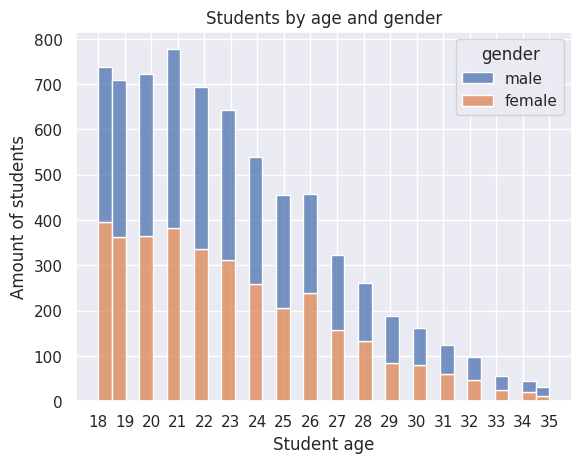

In [ ]:
fig, ax = plt.subplots()
sns.histplot(
    data = query(f'SELECT age, gender from {table};'),
    x = 'age',
    hue = 'gender',
    multiple = 'stack'
)
ax.set_xlabel('Student age')
ax.set_ylabel('Amount of students')
ax.set_title('Students by age and gender')
ax.set_xticks(ticks = np.arange(18, 36, 1))
plt.show()

In [ ]:
# Getting a feel for the distribution of numerical values
for col in df.columns:
    if col not in non_numerical_cols:
        print(query(f'SELECT DISTINCT {col}, COUNT({col}) AS cnt FROM {table} GROUP BY {col};'))
        print('*******************')

    age  cnt
0    18  738
1    19  710
2    20  723
3    21  777
4    22  694
5    23  642
6    24  539
7    25  455
8    26  457
9    27  323
10   28  260
11   29  189
12   30  162
13   31  124
14   32   98
15   33   55
16   34   45
17   35   31
*******************
     cgpa  cnt
0     NaN    0
1    2.44    1
2    2.49    1
3    2.52    2
4    2.58    1
..    ...  ...
139  3.96   26
140  3.97   26
141  3.98   29
142  3.99   27
143  4.00  332

[144 rows x 2 columns]
*******************
   stress_level   cnt
0             0  1098
1             1  1233
2             2  1279
3             3  1405
4             4   992
5             5  1015
*******************
   depression_score   cnt
0                 0  1295
1                 1  1308
2                 2  1304
3                 3  1388
4                 4   884
5                 5   843
*******************
   anxiety_score   cnt
0              0  1243
1              1  1270
2              2  1297
3              3  1429
4              4  

In [ ]:
mns = 'mean_neg_score'
tns = 'total_neg_score'
cur.execute(f'ALTER TABLE {table} ADD COLUMN {mns} REAL;')
cur.execute(f'UPDATE {table} SET {mns} = CAST((anxiety_score + depression_score + financial_stress + stress_level) AS FLOAT) / 4.0 WHERE {mns} IS NULL;')

cur.execute(f'ALTER TABLE {table} ADD COLUMN {tns} INT;')
cur.execute(f'UPDATE {table} SET {tns} = anxiety_score + depression_score + financial_stress + stress_level;')

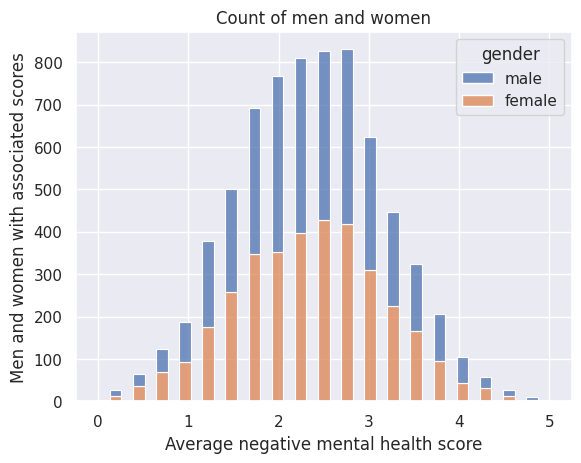

In [ ]:

fig, ax = plt.subplots()
sns.histplot(
    data = query(
        f'SELECT gender, {mns} FROM {table};'
    ),
    x = mns,
    hue = 'gender',
    multiple = 'stack'
)
ax.set_xlabel('Average negative mental health score')
ax.set_ylabel('Men and women with associated scores')
ax.set_title('Count of men and women')
plt.show()

In [ ]:
'''
The entire purpose of this cell is to look at the difference
between the max and the min of the percent values
of each value for mean negative score and for each
non-numerical value as well.
As a result you can view the variance of each categorical in
every score for mean negative score.
'''

neg_cnt = ", ".join([f"ROUND(SUM(CASE WHEN {mns} = {i} THEN 1.0 ELSE 0 END) / COUNT(*) * 100, 2) AS mns_of_{i}" for i in range(0, 6)])
def get_prcnt(col):
    return f'''
SELECT
  {col},
  COUNT(*) AS total_students,
  {mns} AS mean_{mns},
  {neg_cnt}
FROM {table}
GROUP BY {col}
HAVING {col} != "None"
'''

spread = ', '.join([
f'''
  ROUND((MAX(mns_of_{i}) -
  MIN(mns_of_{i})), 2) || "%"
  AS mns_spread_of_{i}
''' for i in range(0, 6)])

get_all_spread = lambda col: f'''
  SELECT
    '{col}' AS category,
    {spread}
  FROM ({get_prcnt(col)}) AS subq
'''
union_statements = ' UNION '.join([get_all_spread(col) for col in non_numerical_cols])
spread_result = query(union_statements + ';')
spread_result

,category,mns_spread_of_0,mns_spread_of_1,mns_spread_of_2,mns_spread_of_3,mns_spread_of_4,mns_spread_of_5
0,chronic_illness,0.04%,0.24%,2.65%,1.1%,0.66%,0.06%
1,counseling_service_use,0.07%,1.14%,4.21%,0.72%,0.62%,0.15%
2,course,0.19%,2.55%,4.87%,4.08%,1.44%,0.1%
3,diet_quality,0.14%,0.74%,1.46%,1.09%,0.8%,0.15%
4,extracurricular_involvement,0.06%,0.73%,0.71%,1.43%,0.37%,0.11%
5,family_history,0.06%,0.45%,0.68%,1.07%,0.32%,0.08%
6,gender,0.03%,0.0%,1.63%,0.02%,0.45%,0.05%
7,physical_activity,0.1%,0.84%,0.86%,1.19%,0.43%,0.11%
8,relationship_status,0.15%,0.8%,0.85%,0.59%,0.58%,0.14%
9,residence_type,0.07%,0.68%,1.47%,0.66%,0.37%,0.03%


In [ ]:
query(get_prcnt('course'))

,course,total_students,mean_mean_neg_score,mns_of_0,mns_of_1,mns_of_2,mns_of_3,mns_of_4,mns_of_5
0,business,717,2.75,0.00,3.91,10.88,7.81,0.70,0.00
1,computer_science,1028,1.75,0.19,1.65,8.75,8.95,2.14,0.10
2,engineering,1072,1.50,0.09,4.20,13.62,7.00,1.21,0.00
3,law,1385,3.25,0.00,2.24,10.04,8.88,1.73,0.07
4,medical,2105,3.50,0.00,2.04,11.12,10.93,1.66,0.10
5,others,715,2.50,0.00,3.36,11.47,6.85,0.84,0.00


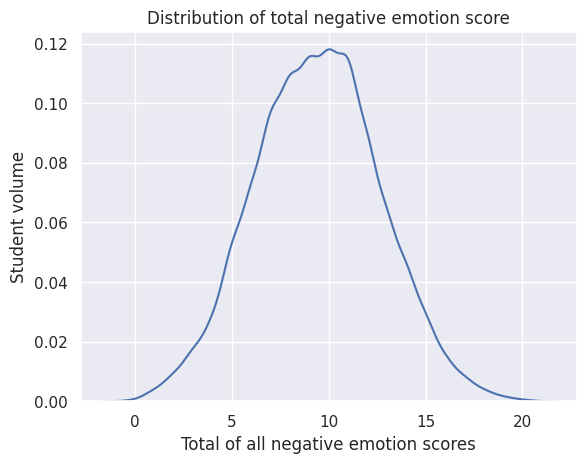

In [ ]:
# Taking a moment to look at the unremarkable normally distributed data
fig, ax = plt.subplots()
sns.kdeplot(query(f'SELECT {tns} FROM {table}'), x = tns)
ax.set_title('Distribution of total negative emotion score')
ax.set_xlabel('Total of all negative emotion scores')
ax.set_ylabel('Student volume')
plt.show()

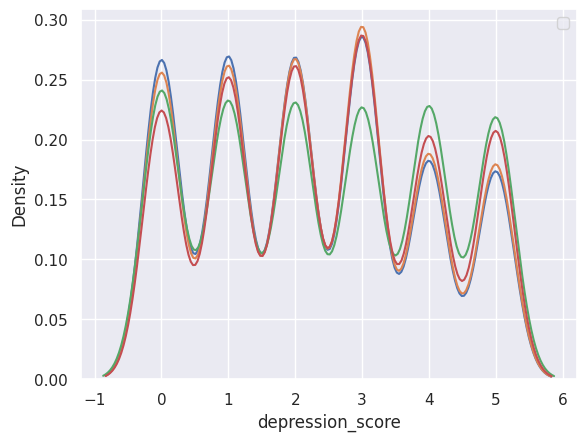

In [ ]:
# Looking at the distribution of mental health scores
for score in ['depression_score', 'anxiety_score', 'financial_stress', 'stress_level']:
    sns.kdeplot(query(f'SELECT {score} FROM {table};'), x = score)
plt.legend()
ax.set_xticks(range(0, 6))
ax.set_yticks([])
ax.set_xlabel('')
ax.set_title('All negative mental health scores')
plt.show()

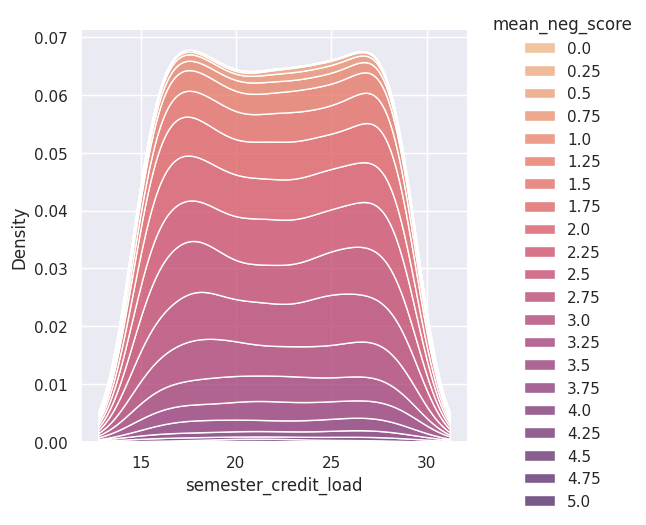

In [ ]:
# Looking at the distribution of mean negative score and semester credit load
sns.displot(query(f'SELECT semester_credit_load, {mns} FROM {table};'), x = 'semester_credit_load', hue = mns, palette = 'flare', kind = 'kde', multiple = 'stack')
ax.set_title('Density of negative score vs credit load')
ax.set_xlabel('Semester credit load')
plt.show()

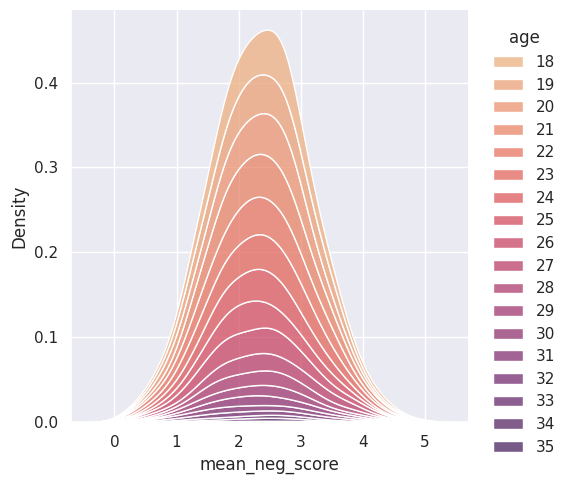

In [ ]:
# Looking at the distribution of age vs mean negative score

sns.displot(query(f'SELECT age, {mns} FROM {table};'), x = mns, hue = 'age', palette = 'flare', kind = 'kde', multiple = 'stack')

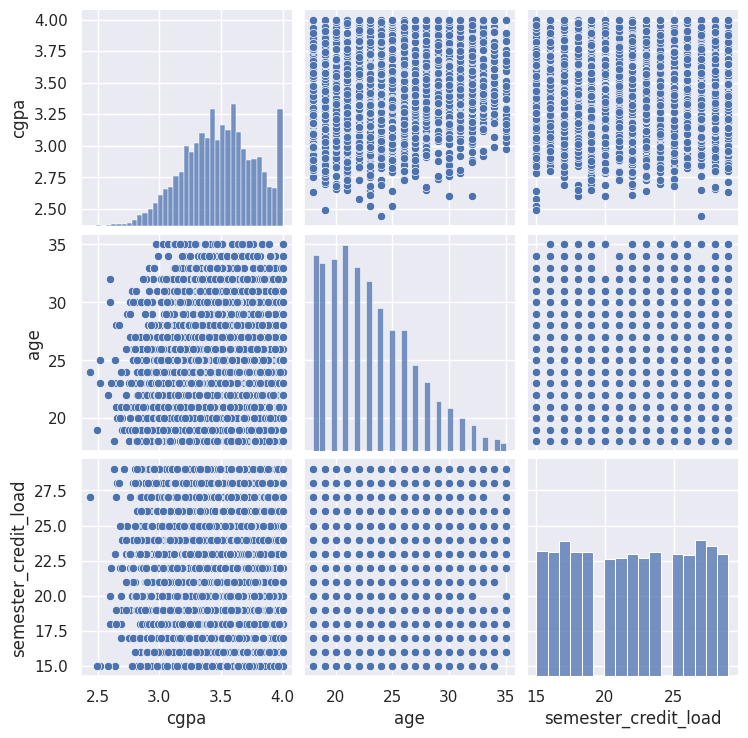

In [ ]:
sns.pairplot(query(f'SELECT cgpa, age, semester_credit_load FROM {table};'))

In [ ]:
# Taking a look at all the categorical variables and their average mean negative score

non_numerical_cols = ['course', 'gender', 'physical_activity','diet_quality',
       'social_support', 'sleep_quality', 'relationship_status',
       'substance_use','counseling_service_use', 'family_history',
       'chronic_illness', 'extracurricular_involvement', 'residence_type']
for col in non_numerical_cols:
    print(query(f'''
    SELECT
      DISTINCT {col},
      COUNT({col}) AS cnt,
      ROUND(CAST(AVG({mns}) AS FLOAT), 2) AS mean_mns
    FROM {table}
    GROUP BY {col};
    '''))
    print('*******************')

             course   cnt  mean_mns
0          business   717      2.16
1  computer_science  1028      2.48
2       engineering  1072      2.18
3               law  1385      2.46
4           medical  2105      2.44
5            others   715      2.19
*******************
   gender   cnt  mean_mns
0  female  3475      2.35
1    male  3547      2.36
*******************
  physical_activity   cnt  mean_mns
0              high  1410      2.38
1               low  2091      2.33
2          moderate  3521      2.37
*******************
  diet_quality   cnt  mean_mns
0      average  4268      2.34
1         good  1385      2.39
2         poor  1369      2.38
*******************
  social_support   cnt  mean_mns
0           high  2176      2.36
1            low  1376      2.40
2       moderate  3470      2.34
*******************
  sleep_quality   cnt  mean_mns
0       average  2735      2.36
1          good  3589      2.36
2          poor   698      2.36
*******************
  relationship_status 

Below is a long winded SQL query meant to normalize the data in the data set for use with a random forest regressor machine learning model.

In [48]:
def generate_case_statements(cat, when, then):
    cat_cases = []

    for c in cat:
        when_then = [
            f"WHEN '{w}' THEN {t}"
            for w, t in zip(when, then)
         ]

        case = f'''
            (CASE {c}
                {" ".join(when_then)}
             END) AS {c}
        '''
        cat_cases.append(case)

    return ', '.join(cat_cases)

lmh = {
    'cat': ["extracurricular_involvement", "physical_activity", "social_support"],
    'when': ['low', 'moderate', 'high'],
    'then': [-1, 0, 1]
}
nof = {
    'cat': ["substance_use", "counseling_service_use"],
    'when': ['never', 'occasionally', 'frequently'],
    'then': [-1, 0, 1]
}
pag = {
    'cat': ['diet_quality', 'sleep_quality'],
    'when': ['poor', 'average', 'good'],
    'then': [-1, 0, 1]
}
gen = {
    'cat': ['gender'],
    'when': ['female', 'male'],
    'then': [0, 1]
}
yn = {
    'cat': ['family_history', 'chronic_illness'],
    'when': ['no', 'yes'],
    'then': [0, 1]
}
relationship_onehot = ', '.join([
  f'''
  (CASE
     WHEN relationship_status = '{rtype}'
     THEN 1 ELSE 0
  END) AS {rtype}
  '''
  for rtype in [
    'single',
    'in_a_relationship',
    'married'
  ]
])
residence_onehot = ', '.join([
  f'''
  (CASE
     WHEN residence_type = '{rtype}'
     THEN 1 ELSE 0
  END) AS {rtype}
  '''
  for rtype in [
    'off_campus',
    'on_campus',
    'with_family'
  ]
])
course_onehot = ', '.join([
  f'''
  (CASE
     WHEN course = '{course}'
     THEN 1 ELSE 0
  END) AS {course}
  '''
  for course in [
    'business',
    'law',
    'computer_science',
    'engineering',
    'medical',
    'others'
  ]
])
cont_num_cols = ['semester_credit_load', 'cgpa', 'age', mns]
generated_statements = ', '.join([generate_case_statements(s['cat'], s['when'], s['then']) for s in [pag, yn, gen, nof, lmh]])

encoded_data = f'''
SELECT
  {", ".join([
    generated_statements,
    residence_onehot,
    relationship_onehot,
    course_onehot,
    *cont_num_cols
  ])}
FROM {table};
'''

# Finish by dropping rows with null values and normalizing numerical variables
model_data = query(encoded_data)
scaler = MinMaxScaler(feature_range = (-1, 1))
model_data[cont_num_cols] = scaler.fit_transform(model_data[cont_num_cols])
model_data = model_data.dropna()
model_data

,diet_quality,sleep_quality,family_history,chronic_illness,gender,substance_use,counseling_service_use,extracurricular_involvement,physical_activity,social_support,...,business,law,computer_science,engineering,medical,others,semester_credit_load,cgpa,age,mean_neg_score
0,1,1,0,0,1,-1.0,-1,0,0,0,...,0,0,0,0,0,1,-0.714286,0.435897,-0.176471,0.0
1,0,0,0,0,0,0.0,0,-1,-1,-1,...,0,0,0,1,0,0,0.714286,-1.000000,-0.294118,-0.4
2,0,1,0,0,0,-1.0,0,1,-1,0,...,1,0,0,0,0,0,-1.000000,0.666667,-0.882353,0.1
4,0,1,0,1,1,-1.0,-1,1,-1,1,...,1,0,0,0,0,0,0.142857,0.230769,-1.000000,0.0
5,1,1,0,0,0,-1.0,-1,0,0,1,...,0,0,0,0,1,0,-0.428571,0.166667,-0.647059,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,0,0,0,0,0,-1.0,0,0,-1,0,...,0,1,0,0,0,0,1.000000,0.141026,-0.764706,-0.4
7017,-1,1,1,0,0,-1.0,1,1,-1,1,...,0,1,0,0,0,0,0.571429,0.602564,-0.764706,0.0
7018,0,1,0,0,0,-1.0,0,-1,0,1,...,0,0,0,0,1,0,-1.000000,0.653846,-0.294118,0.1
7019,-1,1,0,1,1,-1.0,0,0,1,0,...,0,0,0,0,0,1,-0.714286,0.551282,-0.058824,0.4


In [49]:
# Separating training dat and test data

y = model_data[mns]
x = model_data.drop(mns, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35, random_state = 7)

In [50]:
# Fitting and testing the model

test_model = RandomForestRegressor(random_state = 22)
test_model.fit(x_train, y_train)

y_pred = test_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mse

0.1074700195998367

In [51]:
# Creating a dataframe to look at feature importance

feature_importance = pd.DataFrame(
    test_model.feature_importances_ * 100,
    index = x.columns,
    columns = ['importance']
).sort_values(
    by = 'importance',
    ascending = False
)
feature_importance['importance'] = feature_importance['importance'].round(1).astype(str) + '%'
feature_importance

,importance
cgpa,21.3%
semester_credit_load,12.8%
age,12.6%
extracurricular_involvement,4.7%
physical_activity,4.7%
social_support,4.6%
diet_quality,4.5%
sleep_quality,4.2%
counseling_service_use,4.0%
substance_use,2.7%


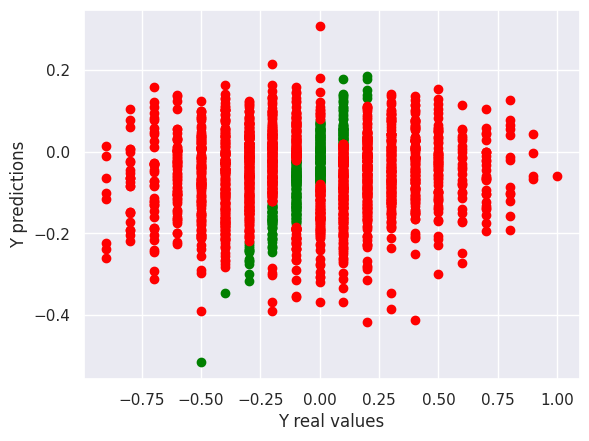

In [55]:
threshold = np.mean(np.abs(y_test - y_pred)) * 0.3
correct = np.abs(y_test - y_pred) <= threshold

fig, ax = plt.subplots()
plt.scatter(y_test[correct], y_pred[correct], color = 'green')
plt.scatter(y_test[~correct], y_pred[~correct], color = 'red')
ax.set_ylabel('Y predictions')
ax.set_xlabel('Y real values')
plt.show()

In [58]:
print(f'Correct values: {sum(correct)}\nIncorrect values: {sum(~correct)}')

Correct values: 450
Incorrect values: 1999
